# Research on Predicting residential electricity consumption patterns based on smart meter and household data in UK

Load and Preprocess the Data

In [15]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score , mean_squared_error

In [16]:
# Load dataset
df = pd.read_csv('LCL-June2015v2_99.csv')

In [17]:
# View dataset
df.head()

,LCLid,stdorToU,DateTime,KWH/hh (per half hour)
0,MAC004221,Std,2013-08-06 07:00:00.0000000,0.046
1,MAC004221,Std,2013-08-06 07:30:00.0000000,0.04
2,MAC004221,Std,2013-08-06 08:00:00.0000000,0.016
3,MAC004221,Std,2013-08-06 08:30:00.0000000,0.018
4,MAC004221,Std,2013-08-06 09:00:00.0000000,0.016


In [18]:
# View Basic Data Information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column                   Non-Null Count    Dtype 
---  ------                   --------------    ----- 
 0   LCLid                    1000000 non-null  object
 1   stdorToU                 1000000 non-null  object
 2   DateTime                 1000000 non-null  object
 3   KWH/hh (per half hour)   1000000 non-null  object
dtypes: object(4)
memory usage: 30.5+ MB


In [19]:
# Convert columns to correct data types
df["DateTime"] = pd.to_datetime(df["DateTime"], errors='coerce')
df["KWH/hh (per half hour) "] = pd.to_numeric(df["KWH/hh (per half hour) "], errors='coerce')

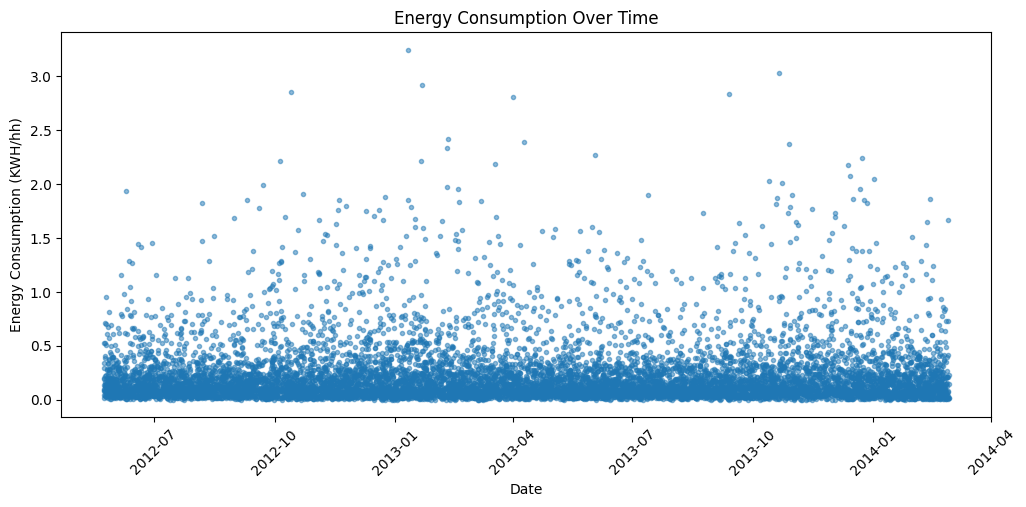

In [21]:
# Time-Series Plot
plt.figure(figsize=(12, 5))
df_sample = df.sample(10000)
plt.plot(df_sample["DateTime"], df_sample["KWH/hh (per half hour) "], alpha=0.5, marker=".", linestyle="None")
plt.xlabel("Date")
plt.ylabel("Energy Consumption (KWH/hh)")
plt.title("Energy Consumption Over Time")
plt.xticks(rotation=45)
plt.show()

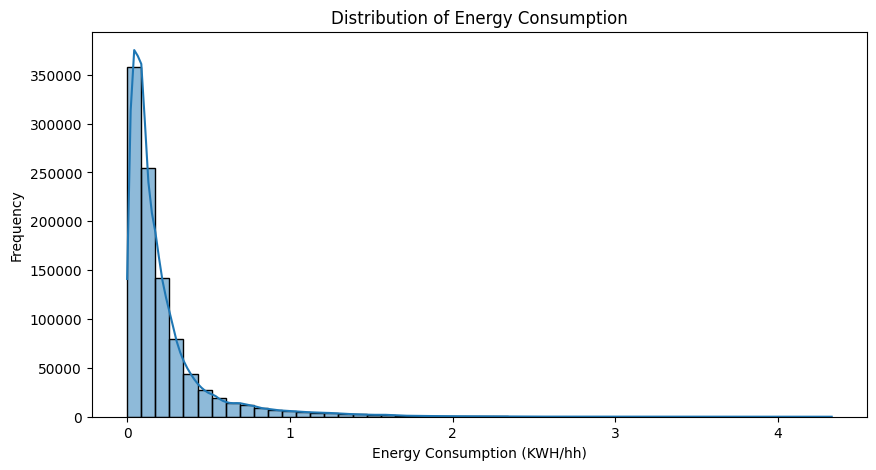

In [22]:
# Distribution Plot
plt.figure(figsize=(10, 5))
sns.histplot(df["KWH/hh (per half hour) "], bins=50, kde=True)
plt.xlabel("Energy Consumption (KWH/hh)")
plt.ylabel("Frequency")
plt.title("Distribution of Energy Consumption")
plt.show()

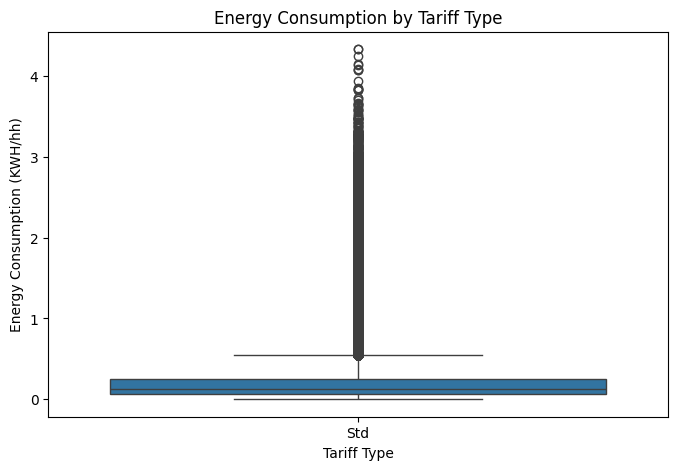

In [23]:
# Box Plot (Tariff Type vs Energy Consumption)
plt.figure(figsize=(8, 5))
sns.boxplot(x="stdorToU", y="KWH/hh (per half hour) ", data=df)
plt.xlabel("Tariff Type")
plt.ylabel("Energy Consumption (KWH/hh)")
plt.title("Energy Consumption by Tariff Type")
plt.show()

In [24]:
# Drop unnecessary columns
df.drop(columns=['LCLid','stdorToU'], inplace=True)

In [25]:
# Data Description
df.describe()

,DateTime,KWH/hh (per half hour)
count,1000000,999965.000000
mean,2013-04-02 14:47:53.520819712,0.219970
min,2012-05-23 10:30:00,0.000000
25%,2012-10-24 20:00:00,0.063000
50%,2013-03-28 14:30:00,0.127000
75%,2013-09-08 10:30:00,0.256000
max,2014-02-28 00:00:00,4.330000
std,NaN,0.282198


In [26]:
# Check for missing values
df.isnull().sum()

,0
DateTime,0
KWH/hh (per half hour),35


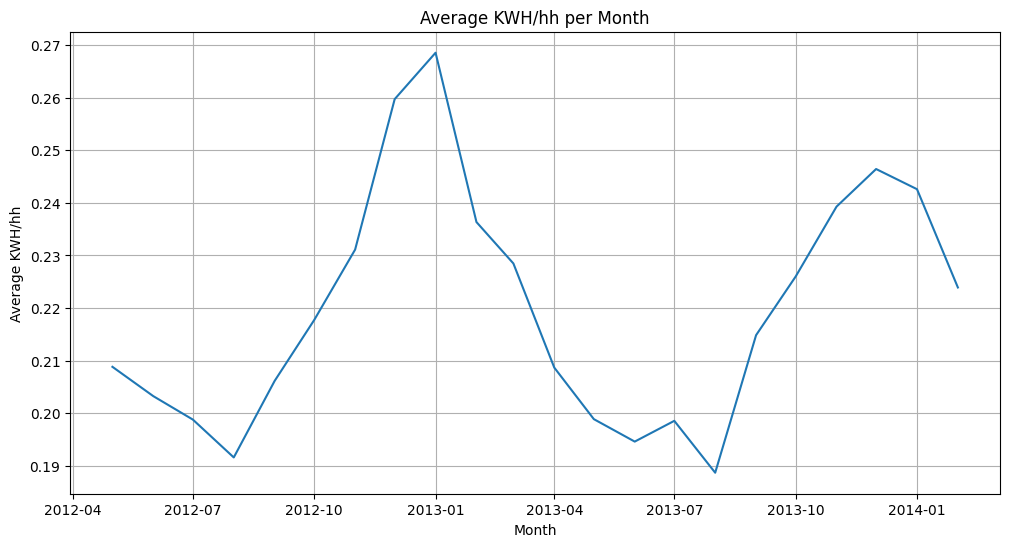

In [27]:
# Convert the 'KWH/hh (per half hour) ' column to numeric, handling errors
df['KWH/hh (per half hour) '] = pd.to_numeric(df['KWH/hh (per half hour) '], errors='coerce')

# Group data by month and calculate the mean KWH/hh for each month
monthly_kwh = df.groupby(df['DateTime'].dt.to_period('M'))['KWH/hh (per half hour) '].mean()

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(monthly_kwh.index.to_timestamp(), monthly_kwh.values)
plt.xlabel('Month')
plt.ylabel('Average KWH/hh')
plt.title('Average KWH/hh per Month')
plt.grid(True)
plt.show()

In [28]:
# Feature Engineering
df['energy_kWh'] = pd.to_numeric(df['KWH/hh (per half hour) '], errors='coerce')
df.dropna(subset=['energy_kWh'], inplace=True)
df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df.set_index('DateTime')

In [29]:
# Data Scaling
scaler = MinMaxScaler()
df['energy_kWh'] = scaler.fit_transform(df[['energy_kWh']])

In [ ]:
# Sequence Creation
sequence_length = 24
data = []
for i in range(len(df) - sequence_length):
  data.append(df['energy_kWh'][i:i + sequence_length])

data = np.array(data)

In [ ]:
# Splitting data
X = data[:, :-1]
y = data[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### RNN Model

In [ ]:
# Reshape for RNN input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# RNN Model
model_rnn = keras.Sequential([
    keras.layers.SimpleRNN(units=50, activation='relu', input_shape=(sequence_length - 1, 1)),
    keras.layers.Dense(units=1)])
model_rnn.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Training
model_rnn.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
24999/24999 ━━━━━━━━━━━━━━━━━━━━ 161s 6ms/step - loss: 0.0014
Epoch 2/10
24999/24999 ━━━━━━━━━━━━━━━━━━━━ 167s 7ms/step - loss: 0.0014
Epoch 3/10
24999/24999 ━━━━━━━━━━━━━━━━━━━━ 201s 7ms/step - loss: 0.0013
Epoch 4/10
24999/24999 ━━━━━━━━━━━━━━━━━━━━ 198s 7ms/step - loss: 0.0013
Epoch 5/10
24999/24999 ━━━━━━━━━━━━━━━━━━━━ 186s 6ms/step - loss: 0.0014
Epoch 6/10
24999/24999 ━━━━━━━━━━━━━━━━━━━━ 200s 6ms/step - loss: 0.0013
Epoch 7/10
24999/24999 ━━━━━━━━━━━━━━━━━━━━ 147s 6ms/step - loss: 0.0013
Epoch 8/10
24999/24999 ━━━━━━━━━━━━━━━━━━━━ 199s 6ms/step - loss: 0.0013
Epoch 9/10
24999/24999 ━━━━━━━━━━━━━━━━━━━━ 205s 6ms/step - loss: 0.0014
Epoch 10/10
24999/24999 ━━━━━━━━━━━━━━━━━━━━ 145s 6ms/step - loss: 0.0014


In [ ]:
# Evaluation
loss = model_rnn.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 0.0013
Test Loss: 0.0013541049556806684


* Prediction

In [ ]:
predictions = model_rnn.predict(X_test)

# Inverse transform the scaled data to get actual values
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Further evaluation
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"RMSE: {rmse}")

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step
RMSE: 0.15933597391663132


In [ ]:
# Convert predictions to class labels
threshold = 0.5
predicted_labels = (predictions > threshold).astype(int)
y_test_labels = (y_test > threshold).astype(int)

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_test_labels, predicted_labels)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9424918370510378


### LSTM Model

In [ ]:
# LSTM Model
lstm_model = keras.Sequential([
    keras.layers.LSTM(units=50, activation='relu', input_shape=(sequence_length - 1, 1)),
    keras.layers.Dense(units=1)])
lstm_model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Training
lstm_model.fit(X_train, y_train, epochs=3, batch_size=64)

Epoch 1/3
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 187s 15ms/step - loss: 0.0015
Epoch 2/3
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 196s 14ms/step - loss: 0.0013
Epoch 3/3
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 200s 14ms/step - loss: 0.0013


In [ ]:
# Evaluation
lstm_loss = lstm_model.evaluate(X_test, y_test)
print(f"LSTM Test Loss: {lstm_loss}")

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - loss: 0.0876
LSTM Test Loss: 0.08839604258537292


In [ ]:
# Prediction
lstm_predictions = lstm_model.predict(X_test)

# Inverse transform the scaled data to get actual values
lstm_predictions = scaler.inverse_transform(lstm_predictions)

# Further evaluation
lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_predictions))
print(f"LSTM RMSE: {lstm_rmse}")

# Convert predictions to class labels
lstm_predicted_labels = (lstm_predictions > threshold).astype(int)

# Calculate accuracy
lstm_accuracy = accuracy_score(y_test_labels, lstm_predicted_labels)
print(f"LSTM Accuracy: {lstm_accuracy}")

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step
LSTM RMSE: 0.15862941555974602
LSTM Accuracy: 0.9430518678527319


## Prophet Model

In [ ]:
# Prepare data for Prophet
prophet_df = df.reset_index()
prophet_df = prophet_df.rename(columns={'DateTime': 'ds', 'energy_kWh': 'y'})

In [ ]:
# Split data into train and test sets
train_prophet = prophet_df[:-int(len(prophet_df) * 0.2)]
test_prophet = prophet_df[-int(len(prophet_df) * 0.2):]

In [ ]:
# Initialize and fit the Prophet model
model_prophet = Prophet()
model_prophet.fit(train_prophet)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8nwezd_s/x9i7bzyz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8nwezd_s/71hdhqx9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68426', 'data', 'file=/tmp/tmp8nwezd_s/x9i7bzyz.json', 'init=/tmp/tmp8nwezd_s/71hdhqx9.json', 'output', 'file=/tmp/tmp8nwezd_s/prophet_modeldqwajwgi/prophet_model-20250304105439.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:54:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:57:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Make predictions on the test set
future = model_prophet.make_future_dataframe(periods=len(test_prophet), freq='30min')
forecast = model_prophet.predict(future)

In [ ]:
# Evaluate the Prophet model
y_true = test_prophet['y'].values
y_pred = forecast['yhat'][-len(test_prophet):].values

In [ ]:
prophet_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"Prophet RMSE: {prophet_rmse}")

Prophet RMSE: 0.05573532818434974


In [ ]:
# Inverse transform the scaled data to get actual values
y_true_actual = scaler.inverse_transform(y_true.reshape(-1, 1))
y_pred_actual = scaler.inverse_transform(y_pred.reshape(-1, 1))

prophet_rmse_actual = np.sqrt(mean_squared_error(y_true_actual, y_pred_actual))
print(f"Prophet RMSE (actual values): {prophet_rmse_actual}")

Prophet RMSE (actual values): 0.2413339654647015


In [ ]:
# Convert predictions to class labels using the same threshold as before
threshold = 0.5
prophet_predicted_labels = (y_pred > threshold).astype(int)
y_true_labels = (y_true > threshold).astype(int)

# Calculate accuracy for Prophet
prophet_accuracy = accuracy_score(y_true_labels, prophet_predicted_labels)
print(f"Prophet Accuracy: {prophet_accuracy}")

Prophet Accuracy: 0.999959998599951


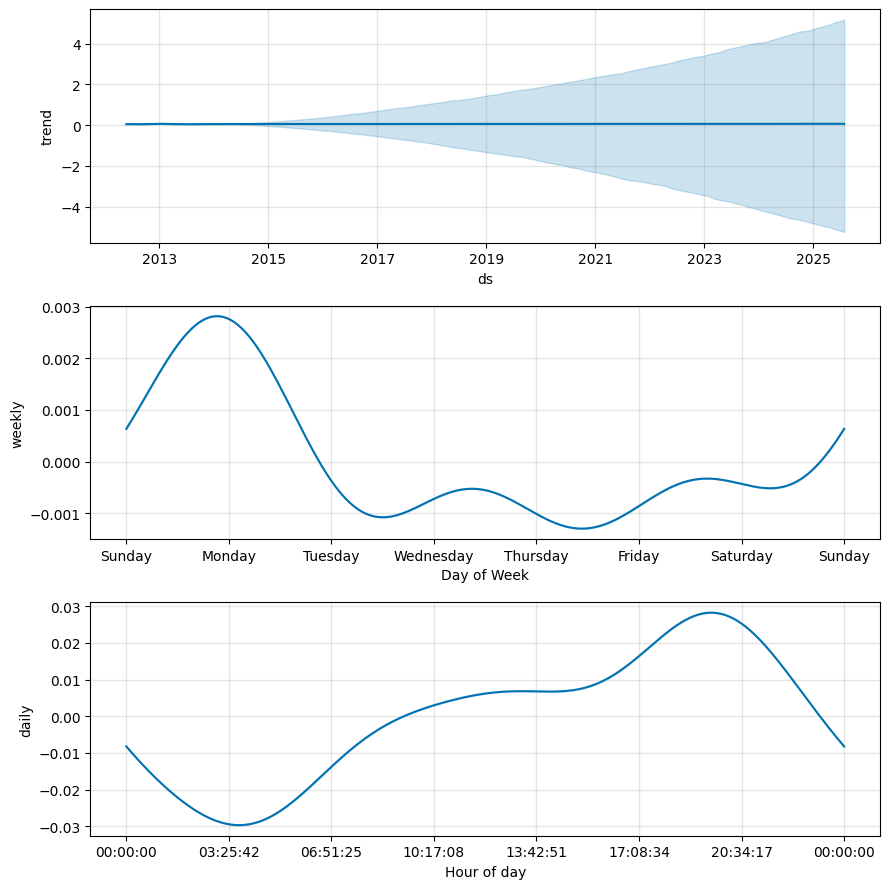

In [ ]:
# Plot components
model_prophet.plot_components(forecast)
plt.show()

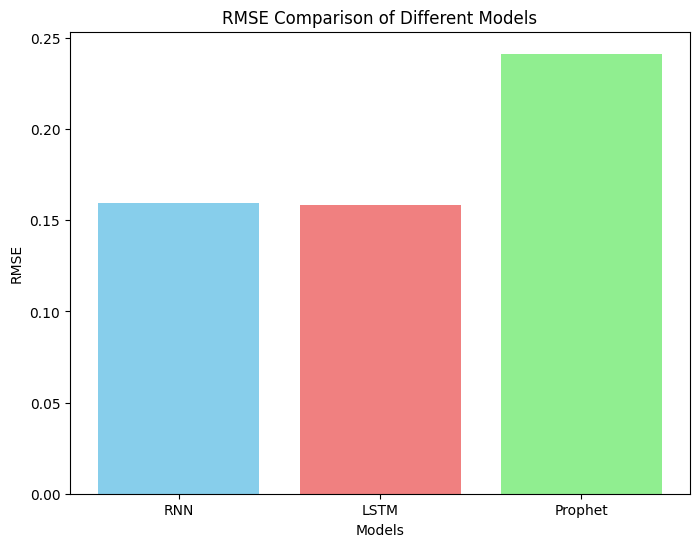

In [ ]:
models = ['RNN', 'LSTM', 'Prophet']
rmse_values = [rmse, lstm_rmse, prophet_rmse_actual]

plt.figure(figsize=(8, 6))
plt.bar(models, rmse_values, color=['skyblue', 'lightcoral', 'lightgreen'])
plt.xlabel("Models")
plt.ylabel("RMSE")
plt.title("RMSE Comparison of Different Models")
plt.show()

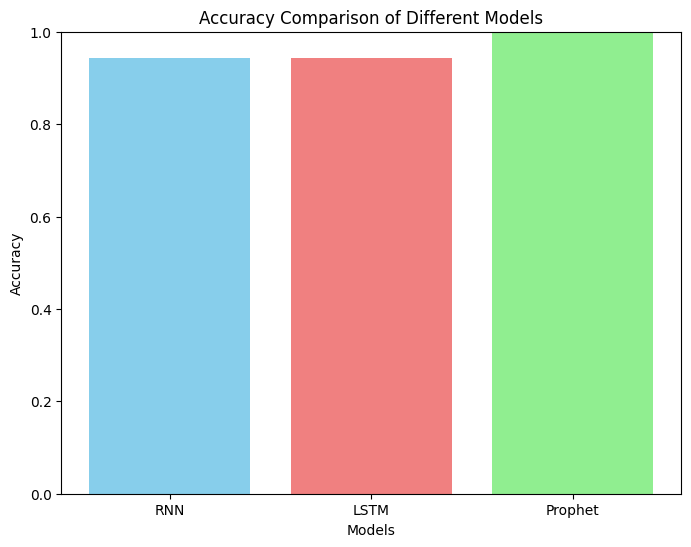

In [ ]:
models = ['RNN', 'LSTM', 'Prophet']
accuracies = [accuracy, lstm_accuracy, prophet_accuracy]

plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['skyblue', 'lightcoral', 'lightgreen'])
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison of Different Models")
plt.ylim(0, 1)
plt.show()